In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier
from keras.applications.vgg16 import VGG16
import random 


In [2]:
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)

set_seeds()
images_dir = ("D:/Machine learning/Datasets/brain/brain_tumor_dataset")
yes_dir = os.path.join(images_dir,'yes')
no_dir = os.path.join(images_dir,'no')

def process(x,y):
    images, labels = [],[]
    for filename in os.listdir(x):
        img_y = cv2.imread(os.path.join(x,filename))
        img_y = cv2.resize(img_y,(256,256),interpolation=cv2.INTER_CUBIC)
        img_y = img_y / 255.0
        images.append(img_y)
        labels.append(1)

    for img in os.listdir(y):
        img_n = cv2.imread((os.path.join(y,img)))
        img_n = cv2.resize(img_n,(256,256),interpolation=cv2.INTER_CUBIC)
        img_n = img_n / 255.0
        images.append(img_n)
        labels.append(0)
   

    image_s = pd.Series(images, name='Image Arrays')
    label_s = pd.Series(labels, name='Labels')
    df = pd.DataFrame(pd.concat([image_s,label_s], axis=1))
    return df

df = process(yes_dir,no_dir)


(256, 256, 3)


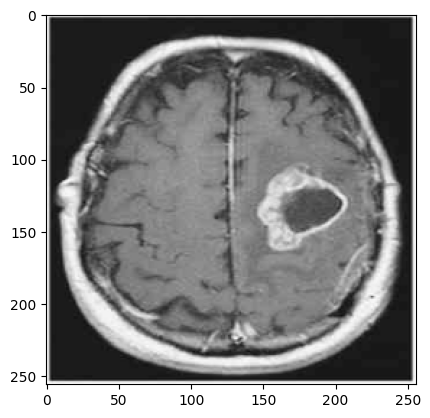

In [3]:
img_array = df.iloc[1,0]
print(img_array.shape)
plt.imshow(img_array)
plt.show()

In [3]:
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode='nearest',
)


In [4]:
X_train, X_test, Y_Train, Y_test = train_test_split(df,df['Labels'],test_size=0.2, random_state=42)
X_train, X_cv,Y_Train, Y_cv = train_test_split(X_train,Y_Train, test_size=0.25, random_state=42)
cv = X_cv["Labels"]
test = X_test['Labels']
train = X_train['Labels']
X_Train = X_train.drop(labels=['Labels'],axis=1)
X_Cv = X_cv.drop(labels=['Labels'],axis=1)
X_Test = X_test.drop(labels=['Labels'],axis=1)
X_Train_array = np.stack(X_Train['Image Arrays'].values)
X_Cv_array = np.stack(X_Cv['Image Arrays'].values)


In [5]:
train_generator = datagen.flow(
    X_Train_array,
    train.values,
    batch_size=32,
    shuffle=True,
)

X_tr, Y_tr = next(train_generator)



In [6]:
early = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=15, verbose=2, restore_best_weights=True, mode='auto')
earlyv2 = keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta=0.01, patience = 15, verbose=2, restore_best_weights=True, mode='auto')
rlronp=keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5,
                                             verbose=1,mode='auto')
model_checkpoint = keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
check_scratch = keras.callbacks.ModelCheckpoint('secondary_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
vgg_2checl =  keras.callbacks.ModelCheckpoint('VGG2.0.keras', monitor='val_accuracy', save_best_only=True, mode='max')
vgg_checkpoint = keras.callbacks.ModelCheckpoint('VGG_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
def new_model(dropout,model1):
    for layer in model1.layers:
        layer.trainable = False
    x = model1.output
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout)(x)
    predictions = keras.layers.Dense(1, activation='sigmoid')(x)
    optimizers = keras.optimizers.Adam(learning_rate=0.00005)
    model = keras.Model(inputs = model1.input, outputs = predictions)
    model.compile(optimizer=optimizers,
              loss = 'binary_crossentropy',
              metrics=['accuracy'],
    )
    return model



dropout = [0.3,0.7,0.8]
model = KerasClassifier(build_fn = new_model,model1 = model1, verbose = 1,dropout=dropout)

param_grid = dict(dropout=dropout)
grid = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 1)
grid_results = grid.fit(X_tr,Y_tr, validation_data=(X_Cv_array, cv))
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
for mean in zip(means):
    print('{0}'.format(mean))



Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.5600 - loss: 0.8343 - val_accuracy: 0.4902 - val_loss: 0.7237
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.6000 - loss: 1.0807 - val_accuracy: 0.4706 - val_loss: 0.6977
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.5385 - loss: 0.9365 - val_accuracy: 0.6275 - val_loss: 0.6503
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.5769 - loss: 0.9397 - val_accuracy: 0.4118 - val_loss: 0.7408
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.4615 - loss: 0.8715 - val_accuracy: 0.5098 - val_loss: 0.6858
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.4800 - loss: 1.4444 - val_accuracy: 0.5098 - val_loss: 0.8526
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.5200 - loss: 1.2395 - val_accuracy: 0.5294 - val_loss: 0.7009
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.4615 - loss: 1.2734 - val_accuracy: 0.5098 - val_loss: 0.7222
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.4231 - loss: 1.1672 - val_accuracy: 0.5098 - val_loss: 0.7196
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.6538 - loss: 0.7165 - val_accuracy: 0.4118 - val_loss: 0.7301
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.6800 - loss: 0.9620 - val_accuracy: 0.4706 - val_loss: 0.6885
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.4800 - loss: 1.6827 - val_accuracy: 0.5098 - val_loss: 0.7364
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.5769 - loss: 1.0641 - val_accuracy: 0.5098 - val_loss: 0.7951
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.4231 - loss: 1.4994 - val_accuracy: 0.4706 - val_loss: 0.7298
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.5385 - loss: 1.4292 - val_accuracy: 0.5098 - val_loss: 0.7934
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.4688 - loss: 0.8025 - val_accuracy: 0.5490 - val_loss: 0.6833
Best: 0.5047619047619047, using {'dropout': 0.3}
(0.5047619047619047,)
(0.49523809523809526,)
(0.5047619047619047,)


In [7]:
def schedluler(epoch,lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.05
schedlule = keras.callbacks.LearningRateScheduler(schedluler)

In [16]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(1, activation='sigmoid')(x) 

model_final = keras.Model(inputs = base_model.input, outputs = predictions)
model_final.compile(optimizer=keras.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'],
)

his = model_final.fit(train_generator, epochs=40, batch_size=64,shuffle=True, validation_data=(X_Cv_array, cv), callbacks=[schedlule,vgg_2checl,rlronp])




Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 7s/step - accuracy: 0.5471 - loss: 1.1975 - val_accuracy: 0.5098 - val_loss: 18.6381 - learning_rate: 0.0010
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - accuracy: 0.6257 - loss: 1.0307 - val_accuracy: 0.6667 - val_loss: 3.1880 - learning_rate: 0.0010
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - accuracy: 0.6136 - loss: 0.7633 - val_accuracy: 0.5098 - val_loss: 8.9831 - learning_rate: 0.0010
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.7316 - loss: 0.5932 - val_accuracy: 0.4902 - val_loss: 13.8749 - learning_rate: 0.0010
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.6710 - loss: 0.8215 - val_accuracy: 0.7843 - val_loss: 1.0410 - learning_rate: 0.0010
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - accuracy: 0.6691 - loss: 0.7329 - val_accuracy: 0.4902 - val_loss: 8.1934 - learning_rate: 0.0010
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - accuracy: 0.6396 - loss: 0.8535 - val_accuracy: 0.6078 - val

Accuracy [0.82] : Changes: 1st layer 512 and last dropout 0.5 
Accuracy [0.84] : Changes: 1st dropout to 0.3
Accuracy [0.84] : Changes: 1nd dropout to 0.2
Accuracy [0.84] : Changes: unfeezing last 5 layers
Accuracy [0.68] : Changes: unfeezing last 7 layers
Accuracy [0.80] : Changes: unfee\zig last 4 layers - 40epochs
Accuracy [0.80] : Changes: unfezing last 9 layers -4o epochs
Accuracy [0.82] : Changes: Unfeezing last 5 layers 25 epochs
Accuracy [0.82] : Changes:5, 512,256
Accuracy [0.86] : Changes:5, 512,512
Accuracy [] : Changes:
Accuracy [] : Changes:
Accuracy [] : Changes:
Accuracy [] : Changes:



In [17]:
vgg_sec = keras.models.load_model('VGG2.0.keras')
vgg_first = keras.models.load_model('VGG_model.keras')
loss, accuact = vgg_first.evaluate(X_Cv_array,cv)
print('Test Accuracy:', accuact)


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.8564 - loss: 0.4998
Test Accuracy: 0.8627451062202454


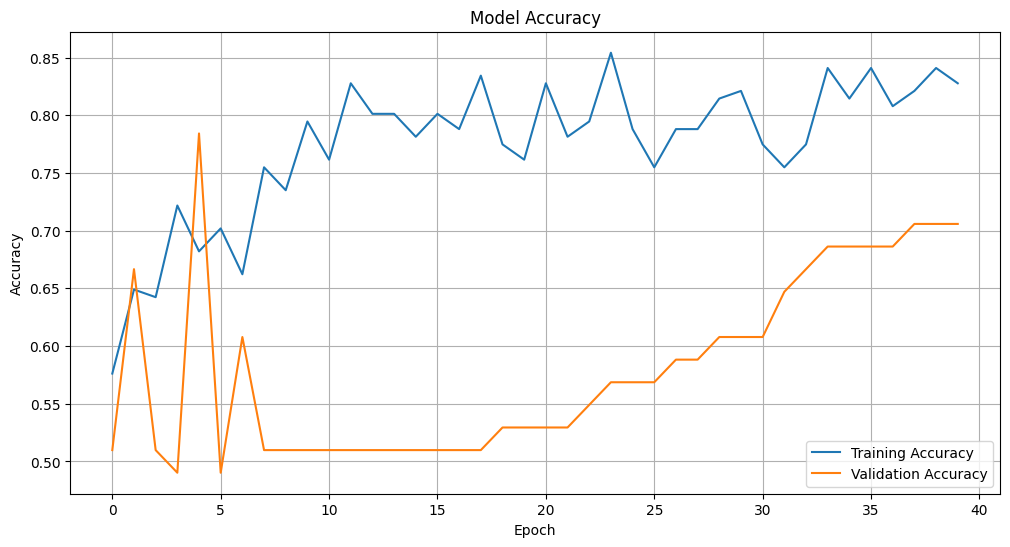

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(his.history['accuracy'], label='Training Accuracy')
plt.plot(his.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [14]:
learning_rate = [5e-6,5e-12,5e-15]
results =  {lr: [] for lr in learning_rate}
score = {lr: 0 for lr in learning_rate}
for values in learning_rate:
    print(f"Current Learning Rate: {values}")
    optimizers = keras.optimizers.Adam(learning_rate=values)
    model_final.compile(optimizer=optimizers,
              loss = 'binary_crossentropy',
              metrics=['accuracy'],
    )
    for epoch in range(10):
        his = model_final.fit(train_generator, epochs= 1, batch_size=32,validation_data=(X_Cv_array,cv), verbose=1)
        val_accuracy = his.history['val_accuracy'][0]
        results[values].append(val_accuracy)

        if val_accuracy > score[values]:
            score[values] = val_accuracy
           
        val_loss = his.history['val_loss'][0]
        print(f"Epoch: {epoch+1}/10 - Loss: {val_loss} - Accuracy: {val_accuracy}")

    valid_loss, valid_acc = model_final.evaluate(X_Cv_array, cv)
    print(f"Validation Accuracy: {valid_acc:.2f}")

    for lr, best_acc in score.items():
        print(f"Learning rate {values}: {best_acc:.2f}")
    
best_score = max(score, key=score.get)
print(f"Best validation Accuracy: {best_score:.2f}, with learning rate: {score[best_score]}")




Current Learning Rate: 5e-06
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.7913 - loss: 0.6828 - val_accuracy: 0.7255 - val_loss: 1.0949
Epoch: 1/10 - Loss: 1.0948864221572876 - Accuracy: 0.7254902124404907
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - accuracy: 0.7978 - loss: 0.7362 - val_accuracy: 0.7451 - val_loss: 1.0643
Epoch: 2/10 - Loss: 1.064332127571106 - Accuracy: 0.7450980544090271
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.7214 - loss: 0.7393 - val_accuracy: 0.7451 - val_loss: 1.0336
Epoch: 3/10 - Loss: 1.0336140394210815 - Accuracy: 0.7450980544090271
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.7548 - loss: 0.7550 - val_accuracy: 0.7451 - val_loss: 1.0104
Epoch: 4/10 - Loss: 1.0103586912155151 - Accuracy: 0.7450980544090271
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.7789 - loss: 0.5579 - val_accuracy: 0.7451 - val_loss: 0.9884
Epoch: 5/10 - Loss: 0.9883956909179688 - Accuracy: 0.7450980544090271
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.7784 -

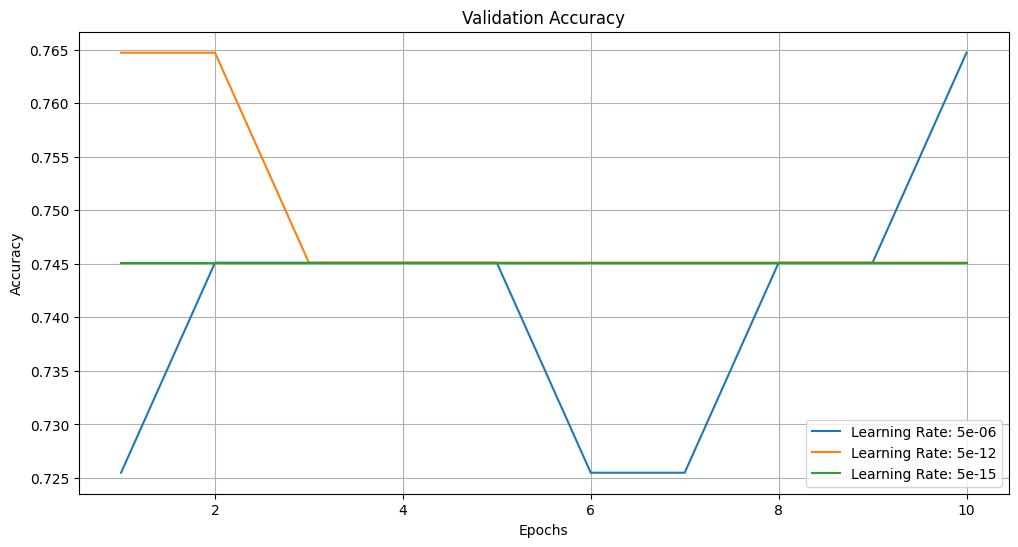

In [15]:
plt.figure(figsize=(12, 6))
for lr, acc in results.items():
    plt.plot(range(1,11), acc,label=f'Learning Rate: {lr}')
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [25]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=64, 
                         kernel_size=3, 
                         activation="relu", 
                         input_shape=(256, 256, 3)), 
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, 
                            padding="valid"),
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.Conv2D(32, 3, activation="relu"), 
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation="relu"), 
  tf.keras.layers.Dense(128, activation="relu"), 
  tf.keras.layers.Dense(1, activation="sigmoid") 
])
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
model_history = model.fit(train_generator, 
                        epochs=50,
                        steps_per_epoch=len(X_Train_array),
                        validation_data=(X_Cv_array,cv)
                        ,shuffle=True,
                        callbacks=[check_scratch])

c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
  5/151 ━━━━━━━━━━━━━━━━━━━━ 6:05 3s/step - accuracy: 0.6365 - loss: 0.7693

c:\Users\Selim\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


151/151 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.6230 - loss: 0.7824 - val_accuracy: 0.5098 - val_loss: 0.7224 - learning_rate: 0.0010
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - accuracy: 0.6777 - loss: 0.6197 - val_accuracy: 0.5686 - val_loss: 0.6658 - learning_rate: 0.0010
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.6816 - loss: 0.5959 - val_accuracy: 0.5098 - val_loss: 0.7105 - learning_rate: 0.0010
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - accuracy: 0.6758 - loss: 0.5904 - val_accuracy: 0.5098 - val_loss: 0.6979 - learning_rate: 0.0010
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.6819 - loss: 0.5855 - val_accuracy: 0.7059 - val_loss: 0.6468 - learning_rate: 0.0010
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.6971 - loss: 0.6283 - val_accuracy: 0.6078 - val_loss: 0.6850 - learning_rate: 0.0010
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.7333 - loss: 0.607

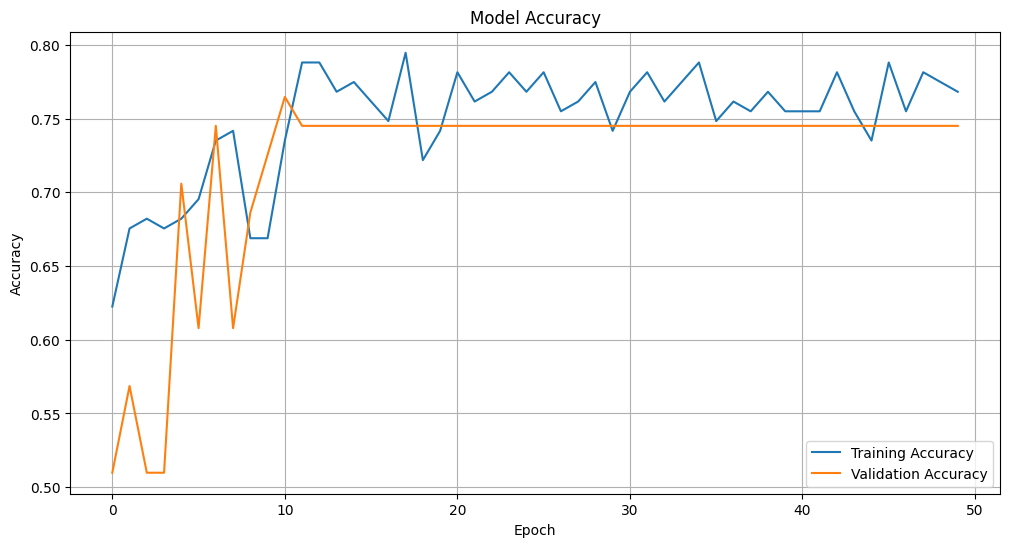

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [23]:
secondary_model = keras.models.load_model('secondary_model.keras')
loss, acc = secondary_model.evaluate(X_Cv_array,cv)
print('Test accuracy:', acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.8068 - loss: 0.5906
Test accuracy: 0.8039215803146362


Best: 0.7523809523809524, using {'layers': (256, 128, 128, 128)}
Best: 0.819047619047619, using {'layers': (256, 128, 128)}
Best: 0.5619047619047619, using {'layers': (256, 128, 128)}
